In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge

import artgor_utils

In [2]:
# X_tr = pd.read_csv('./features/train_features.csv')
# X_test = pd.read_csv('./features/test_features.csv')
# y_tr = pd.read_csv('./features/train_features_label.csv')
X_tr = pd.read_csv('../input/combined_train_features.csv')
X_test = pd.read_csv('../input/combined_test_features.csv')
y_tr = pd.read_csv('../input/combined_y.csv')
print(X_tr.shape)
print(X_test.shape)
print(y_tr.shape)

(4194, 1035)
(2624, 1035)
(4194, 1)


In [3]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_train_scaled = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

---

## define functions

In [4]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=2019)

In [5]:
def train_model(X=X_train_scaled, X_test=X_test_scaled, y=y_tr, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = 8)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=5000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', task_type='GPU',**params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

## XGBoost

In [6]:
xgb_params = {'eta': 0.03,
              'max_depth': 6,
              'subsample': 0.8,
              'objective': 'gpu:reg:linear',
              'eval_metric': 'mae',
              'silent': True,
#               'nthread': 4,
             'tree_method':'gpu_hist'}
oof_xgb, prediction_xgb = train_model(X=X_train_scaled, X_test=X_test_scaled, params=xgb_params, model_type='xgb')

Fold 0 started at Sat May 25 17:57:00 2019
[0]	train-mae:5.09466	valid_data-mae:4.78411
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[92]	train-mae:1.38858	valid_data-mae:1.93877

Fold 1 started at Sat May 25 17:57:05 2019
[0]	train-mae:5.06098	valid_data-mae:5.08403
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[76]	train-mae:1.46893	valid_data-mae:2.11538

Fold 2 started at Sat May 25 17:57:10 2019
[0]	train-mae:5.06323	valid_data-mae:5.06113
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[89]	train-mae:1.40655	valid_data-mae:2.04808

Fold 3 started at Sat May 25 17:57:15 2019
[0]	train-ma

## light gbm

Fold 0 started at Sat May 25 17:57:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[295]	training's l1: 1.42883	valid_1's l1: 1.93741
Fold 1 started at Sat May 25 17:58:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[431]	training's l1: 1.12349	valid_1's l1: 2.07061
Fold 2 started at Sat May 25 17:58:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[548]	training's l1: 0.92577	valid_1's l1: 2.04332
Fold 3 started at Sat May 25 17:58:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[300]	training's l1: 1.40072	valid_1's l1: 2.09351
Fold 4 started at Sat May 25 17:58:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[642]	training's l1: 0.794125	valid_1's l1: 2.05018
Fold 5 started at Sat May 25 17:58:58 2

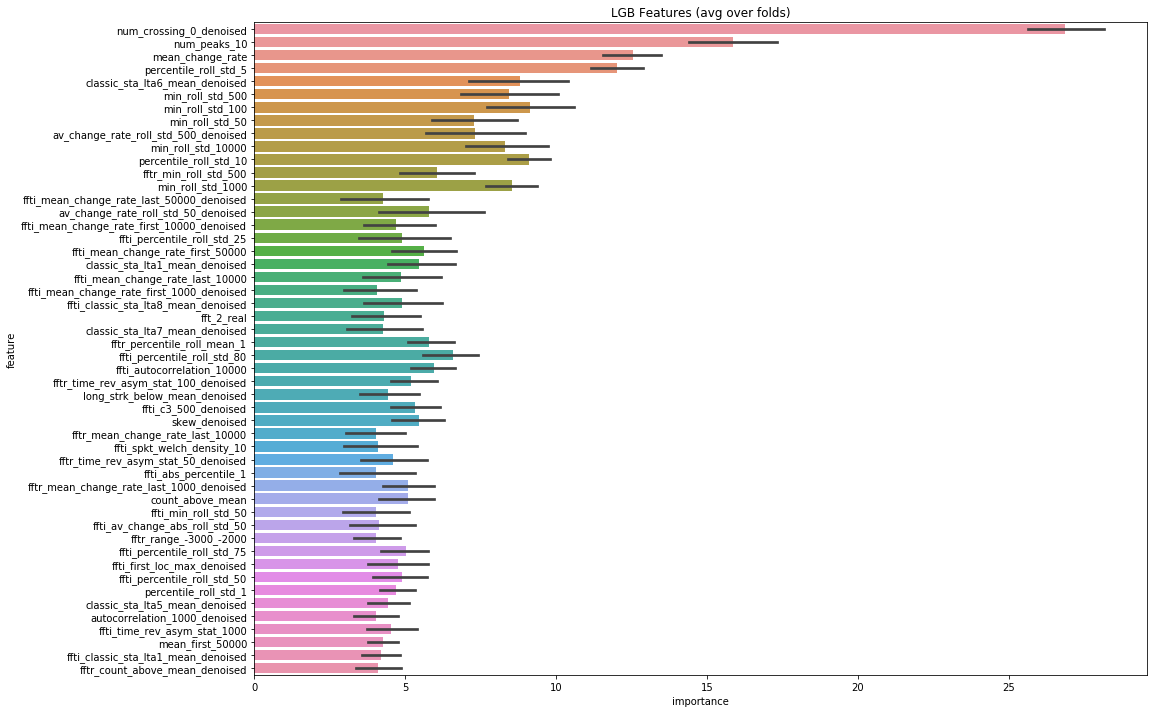

In [7]:
params = {
    'num_leaves': 128,
    'min_data_in_leaf': 60,
    'objective': 'huber',
    'max_depth': -1,
    'learning_rate': 0.03,
    "boosting": "gbdt",
    "bagging_freq": 5,
    "bagging_fraction": 0.8,
    "bagging_seed": 2019,
    "metric": 'mae',
    "verbosity": 1,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
#     'device': 'gpu',
#     'gpu_platform_id': 0,
#     'gpu_device_id': 0
}
oof_lgb, prediction_lgb, feature_importance = train_model(
    params=params, model_type='lgb', plot_feature_importance=True)

In [8]:
# top_cols = list(feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
#                 by="importance", ascending=False)[:50].index)
# Taking less columns seriously decreases score.
# X_train_scaled = X_train_scaled[top_cols]
# X_test_scaled = X_test_scaled[top_cols]

# oof_lgb, prediction_lgb, feature_importance = train_model(X=X_train_scaled, X_test=X_test_scaled, params=params, model_type='lgb', plot_feature_importance=True)

##  NuSVR

In [9]:
model = NuSVR(gamma='scale', nu=0.9, C=10.0, tol=0.01)
oof_svr, prediction_svr = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, model_type='sklearn', model=model)

Fold 0 started at Sat May 25 18:00:06 2019
Fold 0. MAE: 2.0608.

Fold 1 started at Sat May 25 18:00:33 2019
Fold 1. MAE: 2.1485.

Fold 2 started at Sat May 25 18:00:59 2019
Fold 2. MAE: 2.0468.

Fold 3 started at Sat May 25 18:01:26 2019
Fold 3. MAE: 2.2068.

Fold 4 started at Sat May 25 18:01:52 2019
Fold 4. MAE: 2.2431.

Fold 5 started at Sat May 25 18:02:19 2019
Fold 5. MAE: 2.2218.

Fold 6 started at Sat May 25 18:02:45 2019
Fold 6. MAE: 2.1851.

Fold 7 started at Sat May 25 18:03:12 2019
Fold 7. MAE: 2.2046.

Fold 8 started at Sat May 25 18:03:38 2019
Fold 8. MAE: 2.1702.

Fold 9 started at Sat May 25 18:04:05 2019
Fold 9. MAE: 2.2277.

CV mean score: 2.1715, std: 0.0646.


In [10]:
model = NuSVR(gamma='scale', nu=0.7, tol=0.01, C=1.0)
oof_svr1, prediction_svr1 = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, model_type='sklearn', model=model)

Fold 0 started at Sat May 25 18:04:32 2019
Fold 0. MAE: 1.9874.

Fold 1 started at Sat May 25 18:04:52 2019
Fold 1. MAE: 2.1192.

Fold 2 started at Sat May 25 18:05:12 2019
Fold 2. MAE: 2.0008.

Fold 3 started at Sat May 25 18:05:33 2019
Fold 3. MAE: 2.1450.

Fold 4 started at Sat May 25 18:05:53 2019
Fold 4. MAE: 2.1710.

Fold 5 started at Sat May 25 18:06:13 2019
Fold 5. MAE: 2.0377.

Fold 6 started at Sat May 25 18:06:34 2019
Fold 6. MAE: 2.1891.

Fold 7 started at Sat May 25 18:06:54 2019
Fold 7. MAE: 2.1463.

Fold 8 started at Sat May 25 18:07:15 2019
Fold 8. MAE: 2.1212.

Fold 9 started at Sat May 25 18:07:35 2019
Fold 9. MAE: 2.1697.

CV mean score: 2.1087, std: 0.0696.


## Catboost

In [11]:
params = {'loss_function':'MAE'}
oof_cat, prediction_cat = train_model(X=X_train_scaled, X_test=X_test_scaled, params=params, model_type='cat')

Fold 0 started at Sat May 25 18:07:55 2019
Fold 1 started at Sat May 25 18:19:17 2019
Fold 2 started at Sat May 25 18:30:43 2019
Fold 3 started at Sat May 25 18:42:01 2019
Fold 4 started at Sat May 25 18:53:28 2019
Fold 5 started at Sat May 25 19:04:53 2019
Fold 6 started at Sat May 25 19:16:11 2019
Fold 7 started at Sat May 25 19:27:15 2019
Fold 8 started at Sat May 25 19:38:35 2019
Fold 9 started at Sat May 25 19:49:57 2019
CV mean score: 2.0301, std: 0.0561.


## Kernel Ridge

In [17]:
model = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.01)
oof_r, prediction_r = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun May 26 16:30:20 2019
Fold 0. MAE: 3.4756.

Fold 1 started at Sun May 26 16:30:21 2019
Fold 1. MAE: 3.8303.

Fold 2 started at Sun May 26 16:30:22 2019
Fold 2. MAE: 3.6497.

Fold 3 started at Sun May 26 16:30:23 2019
Fold 3. MAE: 3.8815.

Fold 4 started at Sun May 26 16:30:24 2019
Fold 4. MAE: 3.9424.

Fold 5 started at Sun May 26 16:30:25 2019
Fold 5. MAE: 3.6857.

Fold 6 started at Sun May 26 16:30:26 2019
Fold 6. MAE: 3.9702.

Fold 7 started at Sun May 26 16:30:27 2019
Fold 7. MAE: 3.7555.

Fold 8 started at Sun May 26 16:30:27 2019
Fold 8. MAE: 3.7099.

Fold 9 started at Sun May 26 16:30:28 2019
Fold 9. MAE: 3.7118.

CV mean score: 3.7613, std: 0.1416.


# Stackig

In [18]:
train_stack = np.vstack([oof_lgb, oof_xgb, oof_svr, oof_svr1, oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack, columns = ['lgb', 'xgb', 'svr', 'svr1', 'cat'])
test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_svr, prediction_svr1, prediction_cat]).transpose()
test_stack = pd.DataFrame(test_stack)

Fold 0 started at Sun May 26 16:31:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[23]	training's l2: 6.08453	training's l1: 1.94301	valid_1's l2: 7.01016	valid_1's l1: 2.01581
Fold 1 started at Sun May 26 16:31:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[35]	training's l2: 5.62779	training's l1: 1.84557	valid_1's l2: 7.6376	valid_1's l1: 2.13576
Fold 2 started at Sun May 26 16:31:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[25]	training's l2: 6.01437	training's l1: 1.91139	valid_1's l2: 6.87764	valid_1's l1: 2.11203
Fold 3 started at Sun May 26 16:31:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[20]	training's l2: 6.18156	training's l1: 1.95561	valid_1's l2: 7.57023	valid_1's l1: 2.13311
Fold 4 started at Sun May 26 16:31:45 2019
Training until

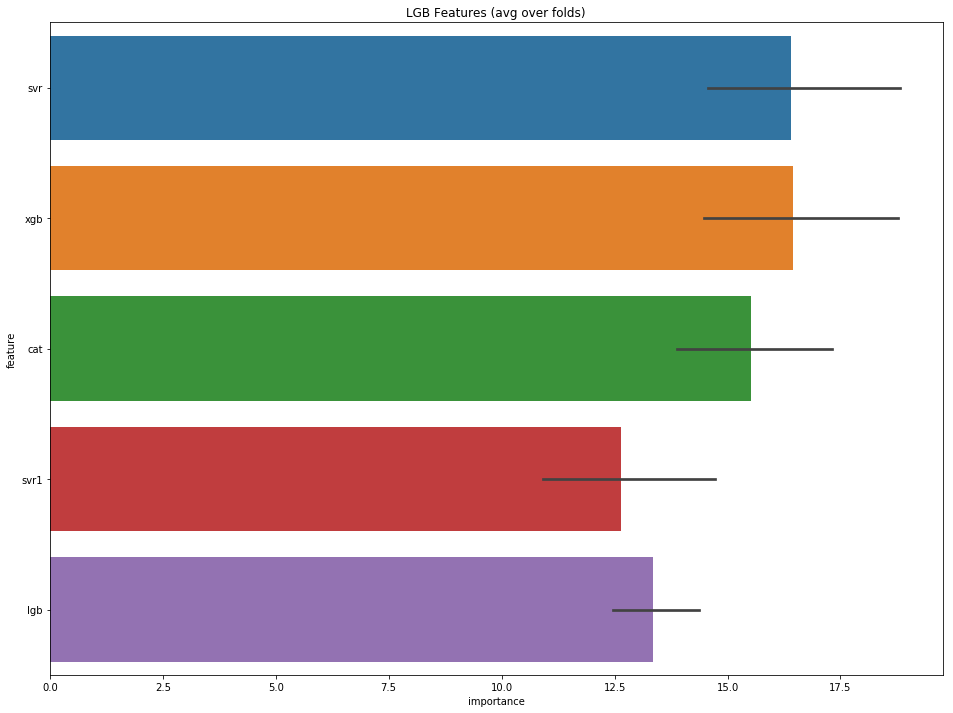

In [19]:
oof_lgb_stack, prediction_lgb_stack, feature_importance = train_model(X=train_stack, X_test=test_stack, params=params, model_type='lgb', plot_feature_importance=True)

In [21]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = (prediction_lgb + prediction_xgb + prediction_svr + prediction_svr1 + prediction_cat) / 5
# submission['time_to_failure'] = prediction_lgb_stack
print(submission.head())
submission.to_csv('../results/combined_features_blending_without_ridge.csv')

            time_to_failure
seg_id                     
seg_00030f         3.655867
seg_0012b5         4.986849
seg_00184e         6.092152
seg_003339         8.979903
seg_0042cc         7.117677
